# CC Scheme

In [281]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from obspy import UTCDateTime, read_inventory
import os
import ccf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [282]:
%matplotlib notebook

In [283]:
client = ccf.Client(sds_root='/Users/psmets/Documents/Research/_data/WaveformArchive')

In [284]:
# general parameters
sampling_rate = 50.
window_length = 86400. # 24h
window_overlap = 21./24. # 3h shift
clip_lag = pd.to_timedelta((0,6),unit='h')
poi = {'name': 'MVC', 'latitude': -25.887, 'longitude': -177.188, 'elevation': 0., 'local_depth': 132.}

attrs = {
    'title': 'Monowai Volcanic Centre',
    'institution': 'Delft University of Technology, Department of Geoscience and Engineering',
    'author': 'Pieter Smets - P.S.M.Smets@tudelft.nl',
    'source': 'CTBTO/IMS hydroacoustic data and IRIS/USGS seismic data',
}

# stream preprocess operations (sequential!)
preprocess = {
    'BHZ': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
        ('running_rms', {}),
    ],
    'BHR': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('rotate', {'method':'->ZNE'}),
        ('rotate', {'method':'NE->RT', 'back_azimuth':250.39 }),
        ('select', {'channel':'BHR'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
        ('running_rms', {}),
    ],
    'EDH': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_sensitivity', {}),
        # ('remove_response', {}),
        ('filter', { 'type': 'bandpass', 'freqmin': 3., 'freqmax': 20. }),
        ('decimate', { 'factor': 5 }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
        ('running_rms', {}),
    ],
}

<IPython.core.display.Javascript object>


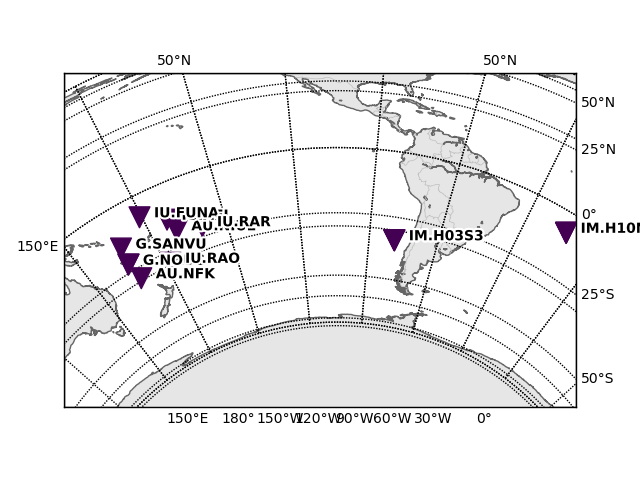

In [285]:
inv = read_inventory('Monowai.xml')
fig = inv.plot(color=0., projection='local')

pairs = [
    'IM.H10N1..EDH-IU.RAR.10.BHZ',
    'IM.H10N1..EDH-IU.RAR.10.BHR',
]
times = pd.date_range('2015-01-15', '2015-02-20', freq='1D')

## Get waveforms

In [189]:
EDH = client.get_waveforms(
    receiver = 'IM.H10N1..EDH', 
    time = pd.to_datetime('2015-01-01T12:00'), 
    verbose = True,
)

Get waveforms for IM.H10N1..EDH from 2014-12-31 23:59:00 until 2015-01-02 00:01:00
Get waveform data for 2014-12-31T00:00:00.000000Z.
Samples in day = 21600000, samples in stream = 21600002, max gaps = 75000.
Waveform data for 2014-12-31T00:00:00.000000Z loaded from archive.
Get waveform data for 2015-01-01T00:00:00.000000Z.
Samples in day = 21600000, samples in stream = 21600002, max gaps = 75000.
Waveform data for 2015-01-01T00:00:00.000000Z loaded from archive.
Get waveform data for 2015-01-02T00:00:00.000000Z.
Samples in day = 21600000, samples in stream = 21600001, max gaps = 75000.
Waveform data for 2015-01-02T00:00:00.000000Z loaded from archive.
Get waveform data for 2015-01-03T00:00:00.000000Z.
Samples in day = 21600000, samples in stream = 21600001, max gaps = 75000.
Waveform data for 2015-01-03T00:00:00.000000Z loaded from archive.


<IPython.core.display.Javascript object>


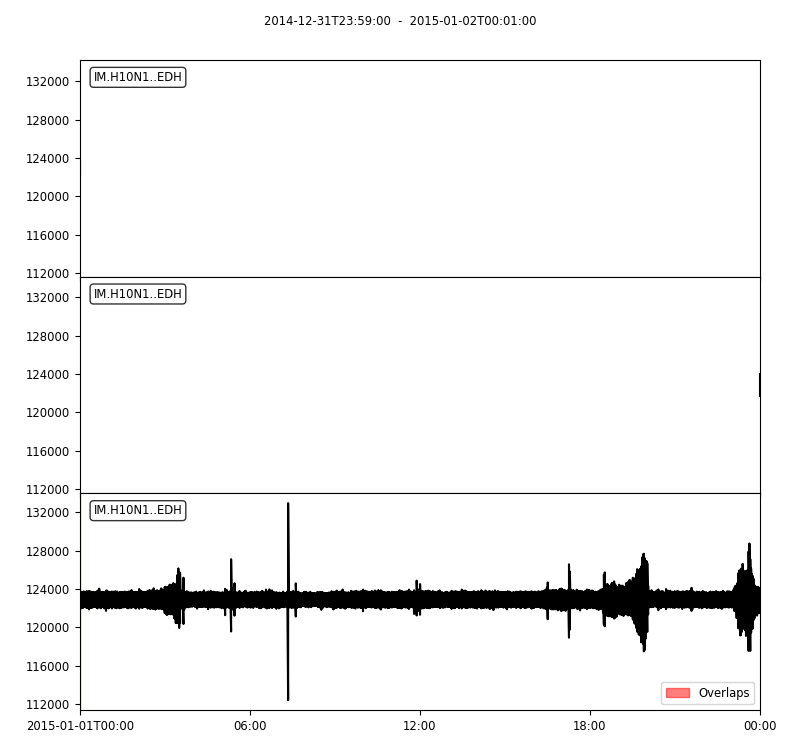

In [190]:
EDH.plot()

In [191]:
EDH = client.get_preprocessed_waveforms(
    receiver = 'IM.H10N1..EDH', 
    time = pd.to_datetime('2015-01-01T12:00'), 
    operations = preprocess,
    inventory = inv,
    verbose = True,
)

5 Trace(s) in Stream:
IM.H10N1..EDH | 2014-12-31T23:59:00.000000Z - 2015-01-01T00:00:00.000000Z | 250.0 Hz, 15001 samples
IM.H10N1..EDH | 2015-01-01T00:00:00.000000Z - 2015-01-01T00:00:00.000000Z | 250.0 Hz, 1 samples
IM.H10N1..EDH | 2015-01-01T00:00:00.000000Z - 2015-01-01T00:00:00.000000Z | 250.0 Hz, 1 samples
IM.H10N1..EDH | 2015-01-01T00:00:00.000000Z - 2015-01-02T00:00:00.000000Z | 250.0 Hz, 21600001 samples
IM.H10N1..EDH | 2015-01-02T00:00:00.000000Z - 2015-01-02T00:01:00.000000Z | 250.0 Hz, 15001 samples
merge :  {'method': 1, 'fill_value': 'interpolate', 'interpolation_samples': 0}
filter :  {'type': 'highpass', 'freq': 0.05}
detrend :  {'type': 'demean'}
remove_sensitivity :  {'inventory': <obspy.core.inventory.inventory.Inventory object at 0x11ba97ed0>}
filter :  {'type': 'bandpass', 'freqmin': 3.0, 'freqmax': 20.0}
decimate :  {'factor': 5}
trim :  {'starttime': UTCDateTime(2015, 1, 1, 0, 0), 'endtime': UTCDateTime(2015, 1, 2, 0, 0)}
detrend :  {'type': 'demean'}
taper :  {'

<IPython.core.display.Javascript object>


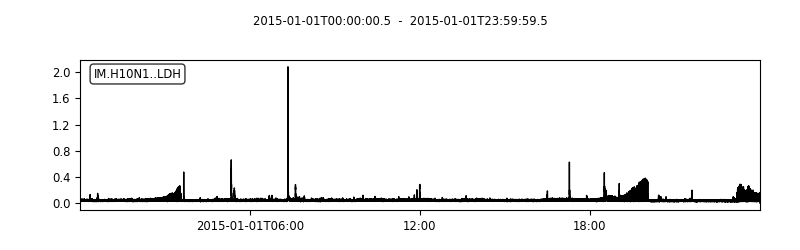

In [193]:
EDH.plot()

In [25]:
inv.get_response('IM.H10N1..EDH',UTCDateTime('2015-01-15'))

Channel Response
	From Pa (Pressure in Pascals) to COUNTS (No Abbreviation Referenced)
	Overall Sensitivity: 1828.15 defined at 10.000 Hz
	0 stages:


In [ ]:
inv.get_response('IM.H03S1..EDH',UTCDateTime('2015-01-15'))

In [26]:
BHZ = client.get_preprocessed_waveforms(
    receiver = 'IU.RAR.10.BHZ', 
    time = pd.to_datetime('2015-01-01T12:00'), 
    operations = preprocess,
    inventory = inv,
    verbose = True,
)

3 Trace(s) in Stream:
IU.RAR.10.BHZ | 2014-12-31T23:58:59.994500Z - 2014-12-31T23:59:59.994500Z | 40.0 Hz, 2401 samples
IU.RAR.10.BHZ | 2015-01-01T00:00:00.019500Z - 2015-01-01T23:59:59.994500Z | 40.0 Hz, 3456000 samples
IU.RAR.10.BHZ | 2015-01-02T00:00:00.019500Z - 2015-01-02T00:00:59.994500Z | 40.0 Hz, 2400 samples
merge :  {'method': 1, 'fill_value': 'interpolate', 'interpolation_samples': 0}
filter :  {'type': 'highpass', 'freq': 0.05}
detrend :  {'type': 'demean'}
remove_response :  {'output': 'VEL', 'inventory': <obspy.core.inventory.inventory.Inventory object at 0x11e197f10>}
filter :  {'type': 'highpass', 'freq': 3.0}
interpolate :  {'sampling_rate': 50, 'method': 'lanczos', 'a': 20}
filter :  {'type': 'lowpass', 'freq': 20.0}
trim :  {'starttime': UTCDateTime(2015, 1, 1, 0, 0), 'endtime': UTCDateTime(2015, 1, 2, 0, 0)}
detrend :  {'type': 'demean'}
taper :  {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.0}


<IPython.core.display.Javascript object>


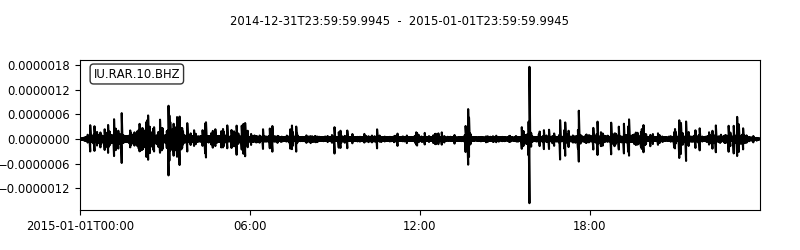

In [27]:
BHZ.plot()

In [ ]:
BHR = ccf.clients.get_preprocessed_stream(
    receiver = 'IU.RAR.10.BHR', 
    time = pd.to_datetime('2015-01-01T12:00'), 
    operations = preprocess,
    inventory = inv,
    verbose = True
)

In [ ]:
BHR.plot()

## Cross-correlate one day of data

In [286]:
pair = pairs[0]
time = times[1]

In [287]:
ds = ccf.init_dataset(
    pair=pair,
    starttime = time,
    endtime = time + pd.offsets.DateOffset(1), 
    attrs = attrs,
    preprocess = preprocess, 
    sampling_rate = sampling_rate, 
    window_length = window_length, 
    window_overlap = window_overlap, 
    clip_lag = clip_lag,
    unbiased = False,
    inventory = inv,
    stationary_poi = poi,
)

In [288]:
ds

<xarray.Dataset>
Dimensions:      (lag: 1080000, pair: 1, time: 8)
Coordinates:
  * pair         (pair) <U27 'IM.H10N1..EDH-IU.RAR.10.BHZ'
  * time         (time) datetime64[ns] 2015-01-16 ... 2015-01-16T21:00:00
  * lag          (lag) timedelta64[ns] 00:00:00 ... 05:59:59.980000
Data variables:
    distance     (pair) float64 1.399e+04
    status       (pair, time) int8 0 0 0 0 0 0 0 0
    pair_offset  (pair, time) timedelta64[ns] 00:00:00 00:00:00 ... 00:00:00
    time_offset  (pair, time) timedelta64[ns] 00:00:00 00:00:00 ... 00:00:00
    cc           (pair, time, lag) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    title:        Monowai Volcanic Centre Crosscorrelations - 2015.016
    history:      Created @ 2020-03-20 16:16:34.103058
    conventions:  CF-1.7
    institution:  Delft University of Technology, Department of Geoscience an...
    author:       Pieter Smets - P.S.M.Smets@tudelft.nl
    source:       CTBTO/IMS hydroacoustic data and IRIS/USGS seismic data
    references:   Bendat, J. Samuel, & Piersol, A. Gerald. (1971). Random dat...
    comment:      n/a
    ccf_version:  0.1.dev46+g7a6a9fd

In [40]:
ds.distance

<xarray.DataArray 'distance' (pair: 1)>
array([13985.34315479])
Coordinates:
  * pair     (pair) <U27 'IM.H10N1..EDH-IU.RAR.10.BHZ'
Attributes:
    long_name:      receiver pair distance
    standard_name:  receiver_pair_distance
    units:          km
    relative_to:    {"name": "MVC", "latitude": -25.887, "longitude": -177.18...

In [49]:
ccf.cc_dataset( ds, inventory=inv, client=client )

IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-16T00:00:00. Waveforms. CC. Done.
IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-16T03:00:00. Waveforms. CC. Done.
IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-16T06:00:00. Waveforms. CC. Done.
IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-16T09:00:00. Waveforms. CC. Done.
IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-16T12:00:00. Waveforms. CC. Done.
IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-16T15:00:00. Waveforms. CC. Done.
IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-16T18:00:00. Waveforms. CC. Done.
IM.H10N1..EDH-IU.RAR.10.BHZ 2015-01-16T21:00:00. Waveforms. CC. Done.


In [44]:
ds

<xarray.Dataset>
Dimensions:      (lag: 1080000, pair: 1, time: 8)
Coordinates:
  * pair         (pair) <U27 'IM.H10N1..EDH-IU.RAR.10.BHZ'
  * time         (time) datetime64[ns] 2015-01-15 ... 2015-01-15T21:00:00
  * lag          (lag) timedelta64[ns] 00:00:00 ... 05:59:59.980000
Data variables:
    distance     (pair) float64 1.399e+04
    status       (pair, time) int8 1 1 1 1 1 1 1 1
    pair_offset  (pair, time) timedelta64[ns] 00:00:00.005500 ... 00:00:00.005500
    time_offset  (pair, time) timedelta64[ns] 00:00:00 00:00:00 ... 00:00:00
    cc           (pair, time, lag) float32 0.0005930746 ... -0.00053902855
Attributes:
    title:        Monowai Volcanic Centre Crosscorrelations - January 2015
    history:      Created @ 2020-03-20 08:08:11.915607
    conventions:  CF-1.7
    institution:  Delft University of Technology, Department of Geoscience an...
    author:       Pieter Smets - P.S.M.Smets@tudelft.nl
    source:       CTBTO/IMS hydroacoustic data and IRIS/USGS seismic data
    references:   Bendat, J. Samuel, & Piersol, A. Gerald. (1971). Random dat...
    comment:      n/a
    ccf_version:  0.1.dev46+g7a6a9fd

Save a netcdf in a safe way (caching in a temp file).

In [50]:
ccf.write_dataset(ds, 'test2.nc')

Write dataset as test2.nc. Close. To temporary netcdf. Replace. Done.


In [ ]:
plt.figure(figsize=[9,4])
ds.cc.loc[{'time':ds.time[:-1],'pair':ds.pair[0]}].plot.line(x='lag',add_legend=False)

In [ ]:
ccf.bias_correct_dataset(ds,unbiased_var='cc_w')

In [68]:
ds1 = ccf.open_dataset('test.nc') 
ds2 = ccf.open_dataset('test2.nc') 

In [70]:
ds1.merge(ds2)

<xarray.Dataset>
Dimensions:      (lag: 1080000, pair: 1, time: 16)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-15 ... 2015-01-16T21:00:00
  * pair         (pair) object 'IM.H10N1..EDH-IU.RAR.10.BHZ'
  * lag          (lag) timedelta64[ns] 00:00:00 ... 05:59:59.980000
Data variables:
    distance     (pair) float64 1.399e+04
    status       (pair, time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    pair_offset  (pair, time) timedelta64[ns] 00:00:00.005500 ... 00:00:00.005500
    time_offset  (pair, time) timedelta64[ns] 00:00:00 00:00:00 ... 00:00:00
    cc           (pair, time, lag) float32 0.0005930746 ... 0.00038044693
Attributes:
    title:        Monowai Volcanic Centre Crosscorrelations - January 2015
    history:      Created @ 2020-03-20 08:08:11.915607
    conventions:  CF-1.7
    institution:  Delft University of Technology, Department of Geoscience an...
    author:       Pieter Smets - P.S.M.Smets@tudelft.nl
    source:       CTBTO/IMS hydroacoustic data and IRIS/USGS seismic data
    references:   Bendat, J. Samuel, & Piersol, A. Gerald. (1971). Random dat...
    comment:      n/a
    ccf_version:  0.1.dev46+g7a6a9fd

In [61]:
ds

<xarray.Dataset>
Dimensions:      (lag: 1080000, pair: 1, time: 16)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-15 ... 2015-01-16T21:00:00
  * pair         (pair) object 'IM.H10N1..EDH-IU.RAR.10.BHZ'
  * lag          (lag) timedelta64[ns] 00:00:00 ... 05:59:59.980000
Data variables:
    distance     (pair) float64 1.399e+04
    status       (pair, time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    pair_offset  (pair, time) timedelta64[ns] 00:00:00.005500 ... 00:00:00.005500
    time_offset  (pair, time) timedelta64[ns] 00:00:00 00:00:00 ... 00:00:00
    cc           (pair, time, lag) float32 0.0005930746 ... 0.00038044693

In [ ]:
plt.figure(figsize=[9,4])
ds.cc_w.loc[{'time':ds.time[1],'pair':ds.pair[0]}].plot.line(x='lag',add_legend=False,color='orange')
ds.cc.loc[{'time':ds.time[1],'pair':ds.pair[0]}].plot.line(x='lag',add_legend=False,color='blue')

### A whole period

In [ ]:
def filename(pair:str,time:pd.datetime):
    return '{pair}.{y:04d}.{d:03d}.nc'.format(pair=pair,y=time.year,d=time.dayofyear)
dest = pwd

In [ ]:
warnings.filterwarnings('ignore') # no warnings of duplicate inventory items

for pair in pairs:
    print('---------------------------')
    print(pair)
    print('---------------------------')
    for time in times:
        ncfile = os.path.join(dest,pair,filename(pair, time))
        if os.path.isfile(ncfile):
            ds = xr.open_dataset(ncfile)
            if np.all(ds.status.values == 1):
                ds.close()
                continue
        else:
            ds = ccf.init_dataset(
                pair=pair, 
                starttime = time, 
                endtime = time + pd.offsets.DateOffset(1), 
                preprocess = preprocess, 
                sampling_rate = sampling_rate, 
                window_length = window_length, 
                window_overlap = window_overlap, 
                title_prefix = title_prefix,
                clip_lag = clip_lag,
                unbiased = False,
                inventory = inv,
                stationary_poi = poi,
            )
        try:
            ccf.cc_dataset(
                ds,
                inventory = inv.select(starttime=UTCDateTime(time),endtime=UTCDateTime(time + pd.offsets.DateOffset(1))),
                retry_missing = True,
            )
        except (KeyboardInterrupt, SystemExit):
            raise
        except Exception as e:
            print('An error occurred. Save and continue next timestep.')
            print('Error:')
            print(e)
        ccf.write_dataset(ds,ncfile)